In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession \
    .builder \
    .appName("Learning Spark") \
    .getOrCreate()

In [3]:
%%time
df = spark.read.json("harvester/claims/*jsonl")

CPU times: user 17.8 ms, sys: 8.24 ms, total: 26 ms
Wall time: 42.6 s


In [4]:
df.count()

1797

In [5]:
df = df.where("version = '0.0.2'")
df.sort(F.col("scraped_at").desc()).show()

+------+-------------+--------------------+--------------------+--------------------+-------+
| claim|      crawler|          scraped_at|                 url|                uuid|version|
+------+-------------+--------------------+--------------------+--------------------+-------+
|156945|ClaimsCrawler|2023-09-29 12:00:...|https://www.occ.c...|8d20bec3-47ff-43a...|  0.0.2|
| 92056|ClaimsCrawler|2023-09-29 12:00:...|https://co.comput...|3bdec3c2-c4ed-458...|  0.0.2|
|129641|ClaimsCrawler|2023-09-29 12:00:...|https://mx.comput...|18817476-7b42-413...|  0.0.2|
|156640|ClaimsCrawler|2023-09-29 08:00:...|https://www.occ.c...|44df88e0-46b2-44f...|  0.0.2|
| 91730|ClaimsCrawler|2023-09-29 08:00:...|https://co.comput...|3b01bf8b-6004-46f...|  0.0.2|
|129288|ClaimsCrawler|2023-09-29 08:00:...|https://mx.comput...|2e4b85f0-4506-4fb...|  0.0.2|
|156538|ClaimsCrawler|2023-09-29 04:00:...|https://www.occ.c...|1ed95523-f07b-440...|  0.0.2|
| 91510|ClaimsCrawler|2023-09-29 04:00:...|https://co.comput

<Figure size 1800x600 with 0 Axes>

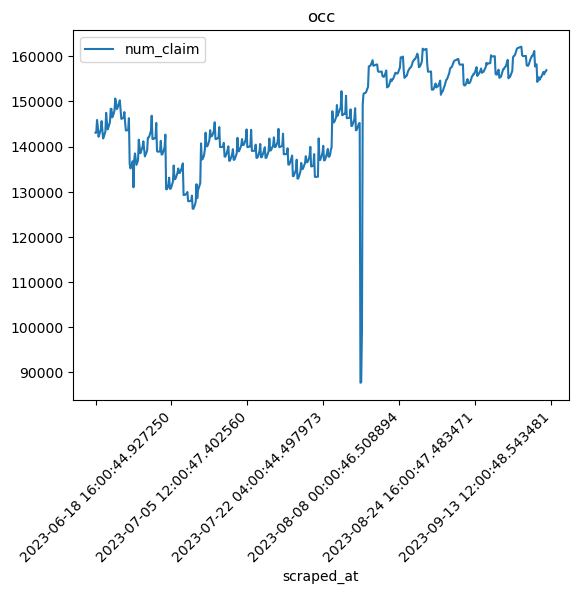

In [6]:
plt.figure(figsize=(18,6))
data = df.where(df.url.startswith("https://www.occ")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.title("occ")
_ = plt.xticks(rotation=45)

In [7]:
data

,claim,crawler,scraped_at,url,uuid,version,num_claim
0,143063,ClaimsCrawler,2023-06-18 16:00:44.927250,https://www.occ.com.mx/empleos/de--/,082e38b5-6379-46b3-ac33-de0a647ffadf,0.0.2,143063
1,143082,ClaimsCrawler,2023-06-18 20:00:44.329050,https://www.occ.com.mx/empleos/de--/,2a30674c-ca13-4da2-a3f9-bfb2adef5545,0.0.2,143082
2,145898,ClaimsCrawler,2023-06-19 00:00:48.557039,https://www.occ.com.mx/empleos/de--/,5b908799-73e2-4106-9b86-f9b97decd67e,0.0.2,145898
3,144438,ClaimsCrawler,2023-06-19 04:00:45.723339,https://www.occ.com.mx/empleos/de--/,7eb416ae-0c05-4a83-8e77-82f65c16657e,0.0.2,144438
4,142183,ClaimsCrawler,2023-06-19 08:00:45.075144,https://www.occ.com.mx/empleos/de--/,4646343c-2338-48b3-bf1b-15588d2586ed,0.0.2,142183
...,...,...,...,...,...,...,...
590,156549,ClaimsCrawler,2023-09-28 20:00:52.820232,https://www.occ.com.mx/empleos/de--/,593b5a97-d269-40f4-a9a4-d91ed442d998,0.0.2,156549
591,156025,ClaimsCrawler,2023-09-29 00:00:50.921319,https://www.occ.com.mx/empleos/de--/,5b642541-db20-4863-a31b-3682aada7372,0.0.2,156025
592,156538,ClaimsCrawler,2023-09-29 04:00:50.512678,https://www.occ.com.mx/empleos/de--/,1ed95523-f07b-4404-9e1e-8695f689b1ce,0.0.2,156538
593,156640,ClaimsCrawler,2023-09-29 08:00:49.903809,https://www.occ.com.mx/empleos/de--/,44df88e0-46b2-44f6-b728-0963c4bf54dd,0.0.2,156640


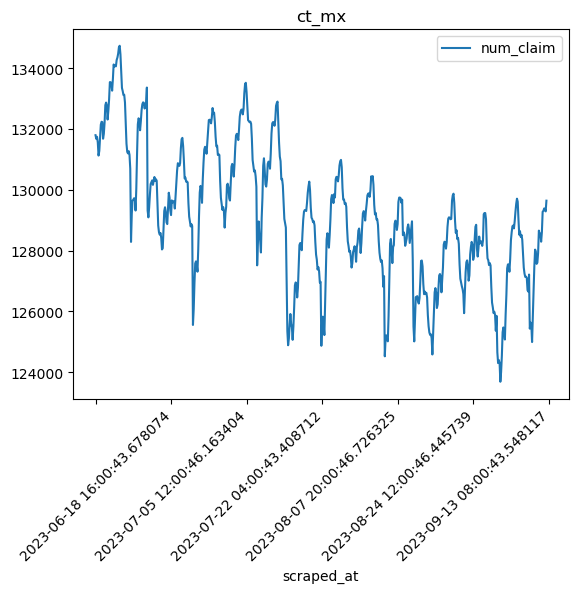

In [8]:
data = df.where(df.url.startswith("https://mx.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.title("ct_mx")
_ = plt.xticks(rotation=45)

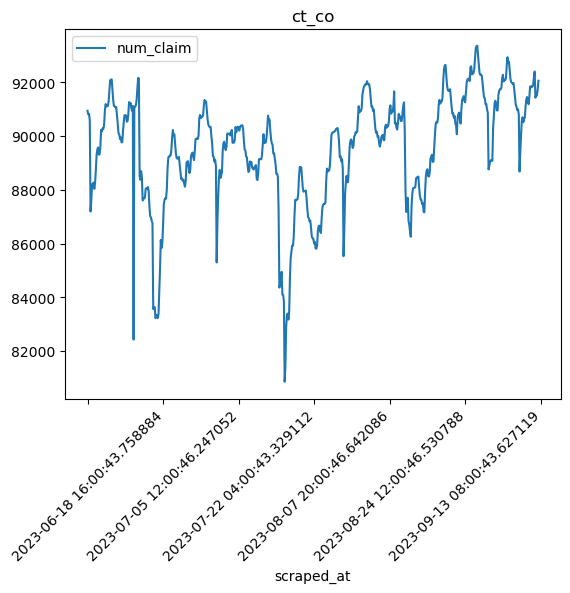

In [9]:
data = df.where(df.url.startswith("https://co.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.title("ct_co")
_ = plt.xticks(rotation=45)

In [10]:
spark.sparkContext.defaultParallelism

4

In [11]:
df.rdd.getNumPartitions()

19

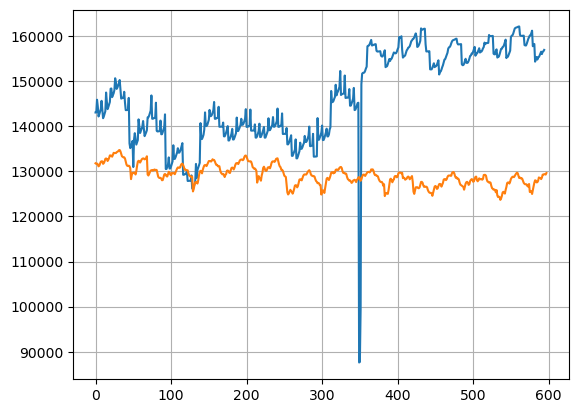

In [12]:
ct = df.where(df.url.startswith("https://mx.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
occ = df.where(df.url.startswith("https://www.occ")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()

plt.plot(occ["num_claim"])
plt.plot(ct["num_claim"])
plt.grid(which="both")
plt.show()

In [13]:
ct_ts["num_claim"]

NameError: name 'ct_ts' is not defined

In [ ]:
occ_ts = occ.set_index("scraped_at")
ct_ts = ct.set_index("scraped_at")
plt.plot(occ_ts.index, occ_ts["num_claim"])
plt.plot(ct_ts.index, ct_ts["num_claim"])

In [ ]:
plt.plot(occ["num_claim"])
plt.plot(ct["num_claim"])
plt.ylim(bottom=0)
plt.show()